In [1]:
!pip install -U tensorflow_addons --quiet
!pip install shap --quiet

In [2]:
# Standard Libraries
from collections import namedtuple
import datetime
import itertools
import os
import warnings
warnings.filterwarnings("ignore")

# Anaconda
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns

# TensorFlow
import tensorflow as tf
import tensorflow_addons as tfa
tf.config.experimental.enable_op_determinism()

# Neural net Explainability
import shap

In [3]:
# For Andre only
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/207 - Applied Machine Learning/project_repo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/207 - Applied Machine Learning/project_repo


In [4]:
# Definition used for hyperparameter tuning
HP_FACTOR = namedtuple("HP_FACTOR", ["name", "values"])

### Initial EDA and Feature Engineering

In [5]:
# Load data
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv")
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [6]:
# Display the number of fields in each column
df.count()

Date                    10129
Time                    10129
S1_Temp                 10129
S2_Temp                 10129
S3_Temp                 10129
S4_Temp                 10129
S1_Light                10129
S2_Light                10129
S3_Light                10129
S4_Light                10129
S1_Sound                10129
S2_Sound                10129
S3_Sound                10129
S4_Sound                10129
S5_CO2                  10129
S5_CO2_Slope            10129
S6_PIR                  10129
S7_PIR                  10129
Room_Occupancy_Count    10129
dtype: int64

In [7]:
# Identify the type of each column
df.dtypes

Date                     object
Time                     object
S1_Temp                 float64
S2_Temp                 float64
S3_Temp                 float64
S4_Temp                 float64
S1_Light                  int64
S2_Light                  int64
S3_Light                  int64
S4_Light                  int64
S1_Sound                float64
S2_Sound                float64
S3_Sound                float64
S4_Sound                float64
S5_CO2                    int64
S5_CO2_Slope            float64
S6_PIR                    int64
S7_PIR                    int64
Room_Occupancy_Count      int64
dtype: object

In [8]:
# Identify whether the data has any missing values
df.isna().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

In [9]:
# Create a more user-friendly "Timestamp" feature from "Date" and "Time" columns
timestamp = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y/%m/%d%H:%M:%S")
df.insert(0, "Timestamp", timestamp)

In [10]:
# General statistics of the data
df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


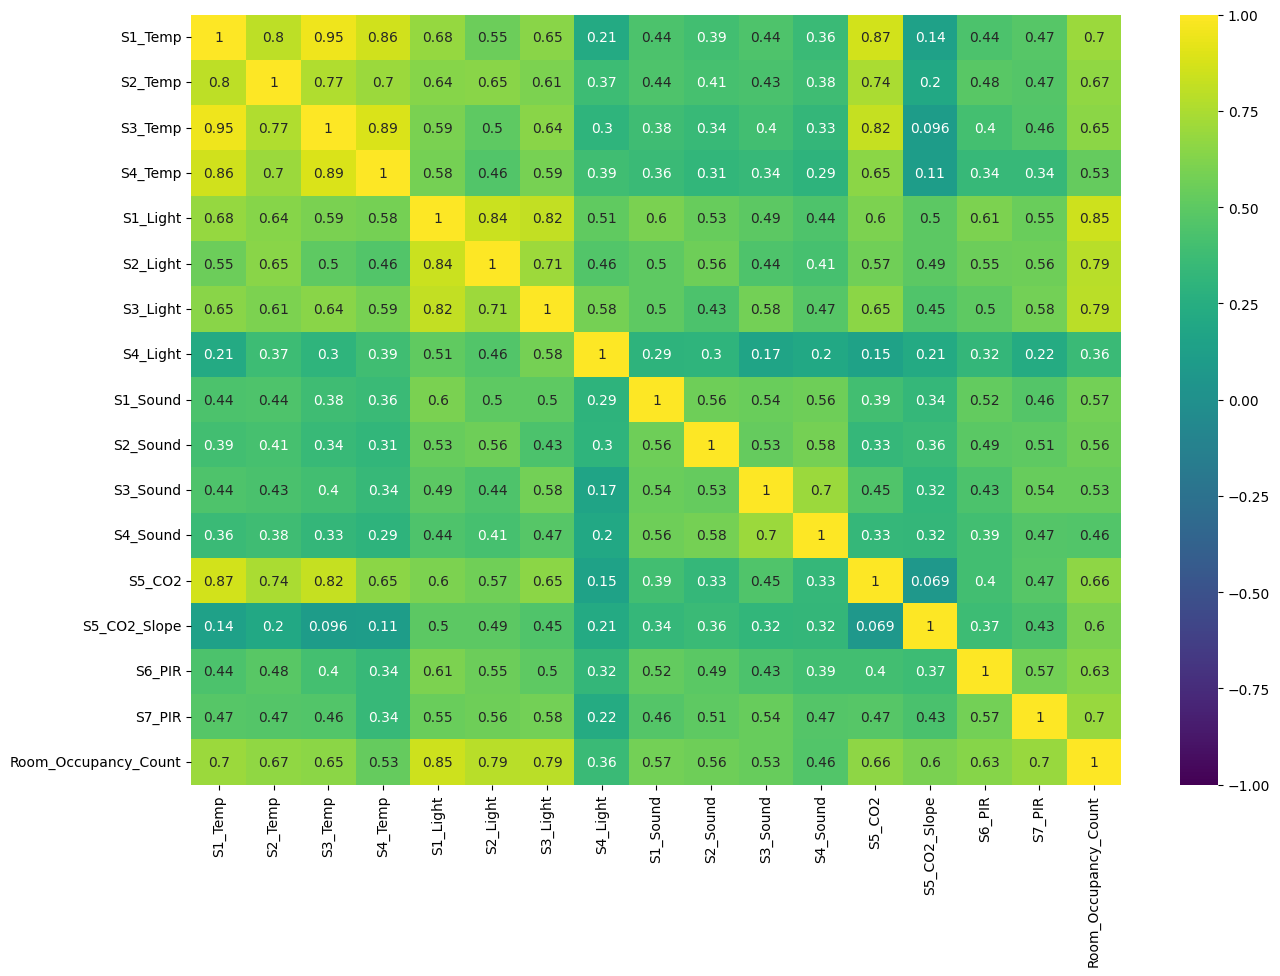

In [11]:
# Correlation of all the columns in the dataframe
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(data=df.corr(), vmin=-1, vmax=1, cmap="viridis", annot=True, ax=ax)
plt.show()

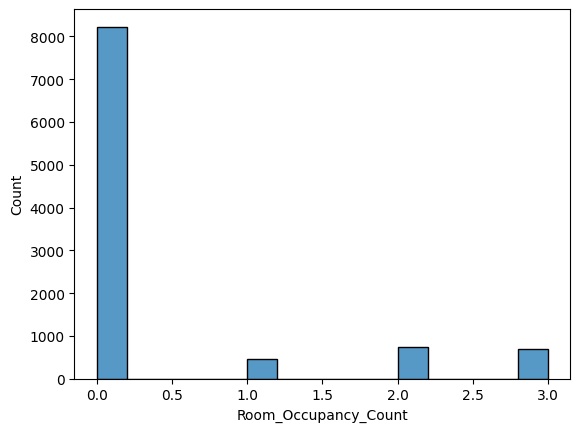

In [12]:
# Explore the distribution of classes
sns.histplot(df["Room_Occupancy_Count"])
plt.show()

In [13]:
# Explore the details of when rooms are empty/occupied
min_occupied_time = df[df["Room_Occupancy_Count"].ge(1)]["Timestamp"].dt.time.min()
max_occupied_time = df[df["Room_Occupancy_Count"].ge(1)]["Timestamp"].dt.time.max()

min_unoccupied_time = df[df["Room_Occupancy_Count"] == 0]["Timestamp"].dt.time.min()
max_unoccupied_time = df[df["Room_Occupancy_Count"] == 0]["Timestamp"].dt.time.max()

print(f"Min/Max Occupied Time: {min_occupied_time}/{max_occupied_time}")
print(f"Min/Max Unoccupied Time: {min_unoccupied_time}/{max_unoccupied_time}")

Min/Max Occupied Time: 10:49:41/19:51:46
Min/Max Unoccupied Time: 00:00:28/23:59:58


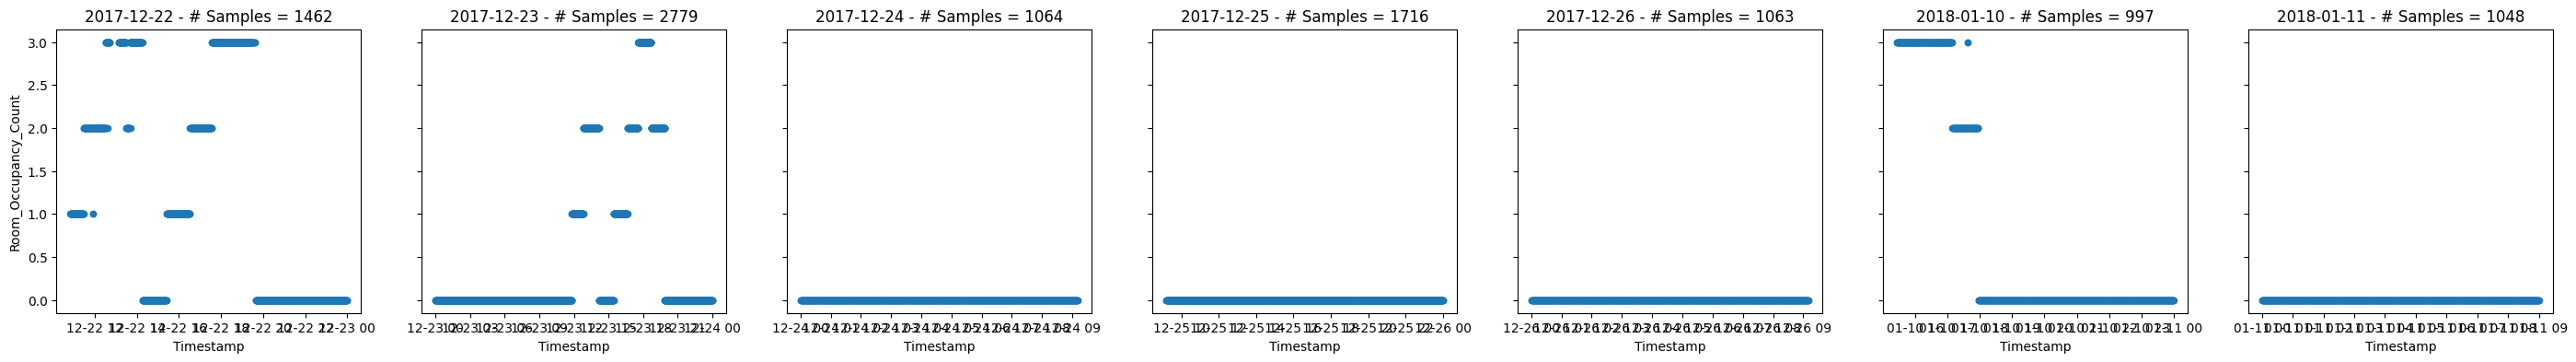

In [14]:
# Visualize when rooms are empty/occupied
fig, axes = plt.subplots(1, df["Timestamp"].dt.date.nunique(), sharey=True, figsize=(35, 4))

for date, ax in zip(df["Timestamp"].dt.date.unique(), axes):
    subset = df[df["Timestamp"].dt.date == date]
    subset.plot(x="Timestamp", y="Room_Occupancy_Count", kind="scatter", ax=ax)
    ax.set_title(f"{date} - # Samples = {len(subset)}")
plt.show()

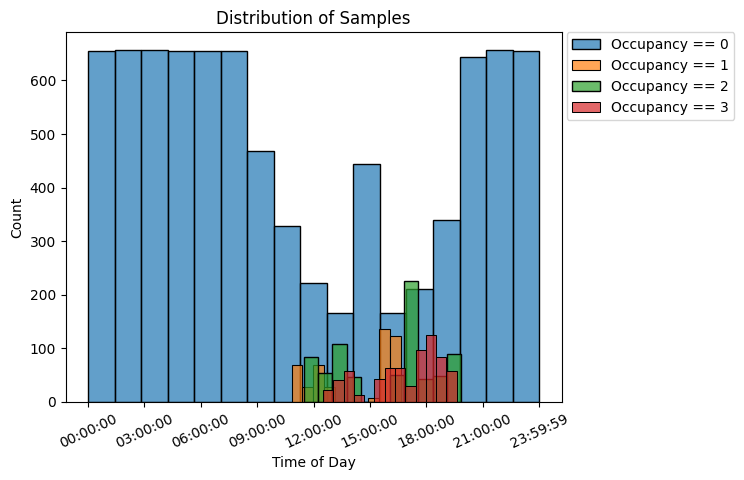

In [15]:
# Plot count of samples by occupancy and time
def time_to_seconds(x):
    """ Function for converting datetime.time object to seconds since midnight """
    return (x.hour * 60 + x.minute) * 60 + x.second


seconds = df["Timestamp"].dt.time.apply(time_to_seconds)

for occupancy_count in sorted(df["Room_Occupancy_Count"].unique()):
    sns.histplot(
        data=seconds[df.Room_Occupancy_Count.eq(occupancy_count)],
        label=f"Occupancy == {occupancy_count}",
        alpha=0.7
    )

x_labels = [datetime.time(i, 0, 0) for i in range(0, 22, 3)] + [datetime.time(23, 59, 59)]
x_ticks = [time_to_seconds(i) for i in x_labels]
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=25)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
plt.xlabel("Time of Day")
plt.title("Distribution of Samples")
plt.show()

# Pipeline

### Define Functions

In [16]:
def split_data(X, y, split=(0.6, 0.2, 0.2), random_seed=888):
    """
    Splits X/y into training, validation, and testing sets based on the
    specified split.

    Parameters
    ----------
    X : np.ndarray
        An array-like collection of sample points
    y : np.ndarray
        The class labels of the data, should match the length of data
    split : tuple
        The percentage allocation of training, validation, and test datasets
        Default: (0.6, 0.2, 0.2)
    random_seed : int
        The seed for the random number generator
        Default: 888

    Returns
    -------
    splits : tuple
        The training, validation, and test datasets with their labels
    """
    # Input checking
    if len(X) != len(y):
        raise ValueError(f"X and y lengths don't match ({len(X)} != {len(y)})")
    if len(split) != 3:
        raise ValueError("Invalid split, expected 3 percentages (training, validation, test)")
    if sum(split) != 1:
        raise ValueError(f"Invalid split {split}, percentages must sum to 1!")
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("X and y must be numpy arrays")

    # Initial split for testing data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=split[2], random_state=random_seed, stratify=y
    )

    # Further split for validation data
    val_size = split[1] / (1 - split[2])
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=random_seed, stratify=y_train
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [17]:
def calculate_f1_scores(true_labels, predicted_labels, labels=[0, 1, 2, 3], print_output=True):
    """
    Calculates the macro average f1-score, micro average f1-score, and weighted
    average f1-score from the given true and predicted labels

    Parameters
    ----------
    true_labels : np.ndarray
        An array-like collection of the true labels a model is trying to predict
    predicted_labels : np.ndarray
        An array-like collection of the predicted labels output from a model
    labels : list
        The set of unique class labels in the given classification problem
        Default: [0, 1, 2, 3]
    print_output : bool
        Whether to print the metrics out or not
        Default : True

    Returns
    -------
    macro_avg_f1 : float
        The macro average f1-score for the model. The function calculates the f1-score
        for each class individually and takes the unweighted mean of all values    
    micro_avg_f1 : float
        The micro average f1-score for the model. The function considers the total
        True Negatives (TN) and total False Positives (FP) amongst all classes and
        calculates the f1-score globally for the model
    weighted_avg_f1: float
        The support weighted average f1-score for the model. The function calculates
        the f1-score for each class individually and takes the weighted mean of all
        values based on the support of each class
    """

    # Calculate metrics
    macro_avg_f1 = f1_score(true_labels, predicted_labels, labels=labels, average="macro")
    micro_avg_f1 = f1_score(true_labels, predicted_labels, labels=labels, average="micro")
    weighted_avg_f1 = f1_score(true_labels, predicted_labels, labels=labels, average="weighted")

    # Print metrics
    if print_output:
        print("F1-Scores")
        print("---------")
        print(f"Macro average: {macro_avg_f1:9.4f}")
        print(f"Micro average: {micro_avg_f1:9.4f}")
        print(f"Weighted average: {weighted_avg_f1:.4f}\n")

    return macro_avg_f1, micro_avg_f1, weighted_avg_f1

In [18]:
def plot_history(history, save_path=None, save_kwgs={}):
    """
    Plots the training/validation loss for a TensorFlow model

    Parameters
    ----------
    history : pandas DataFrame
        The dataframe of history from the TensorFlow model fit step
    save_path : str
        The path to which to save the image
        Default : None (no output saved)
    save_kwgs : dict
        A dictionary mapping plt.savefig arguments to values
        Default : {}
    """
    plt.plot(history["loss"], label="Training", marker="o", color="#e03636")
    plt.plot(history["val_loss"], label="Validation", marker="o", ls="--", color="#595e93")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, **save_kwgs)

    plt.show()

In [19]:
def plot_roc(y_true, y_pred_prob, n_classes=4, save_path=None, save_kwgs={}):
    """
    Plots the ROC curve for the given data and includes the macro-averaged
    AUC score for each class in the plot label

    Parameters
    ----------
    y_true : array_like
        The one-hot encoded true labels
    y_pred_prob : array_like
        The predicted probabilities out of the ML model
    n_classes : int
        The number of classes in the classification problem
        Default : 4
    save_path : str
        The path to which to save the image
        Default : None (no output saved)
    save_kwgs : dict
        A dictionary mapping plt.savefig arguments to values
        Default : {}
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    for class_id in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, class_id],  y_pred_prob[:, class_id])
        auc = roc_auc_score(y_true[:, class_id],  y_pred_prob[:, class_id])
        ax.plot(fpr, tpr, label=f"Occupancy=={class_id} (AUC = {auc:0.3f})", alpha=0.7)

    ax.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.5)")

    ax.axis("square")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("One-vs-Rest ROC Curves")
    ax.legend()

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, **save_kwgs)

    plt.show()

### Load and Prepare Data

In [20]:
# Load data
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv")

# Combine "Date" and "Time" columns into a single timestamp
timestamp = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y/%m/%d%H:%M:%S")
df.insert(0, "Timestamp", timestamp)
df.drop(columns=["Date", "Time"], inplace=True)

# Save feature and target names
features = df.columns[:-1]
labels = df.columns[-1]

# Convert dataframe into numpy arrays of data
X = df[features].values
y = df[labels].values

# Train/validation/test split
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# Downsample to time windows where rooms are occupied due to class imbalance
min_occupied_time = df[df["Room_Occupancy_Count"] == 1]["Timestamp"].dt.time.min()
max_occupied_time = df[df["Room_Occupancy_Count"] == 1]["Timestamp"].dt.time.max()

mask_func = np.vectorize(lambda x: (x.time() > min_occupied_time) & (x.time() < max_occupied_time))
mask = mask_func(X_train[:, 0])

X_train = X_train[mask]
y_train = y_train[mask]

# Downsampling done, no longer need "Timestamp" feature 
features = features[1:]
X_train = X_train[:, 1:]
X_val = X_val[:, 1:]
X_test = X_test[:, 1:]

# Helpful variables
n_features = len(features)
n_classes = df[labels].nunique()

# Concatenate train and val subsets into one set for post hyperparameter tuning training
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

# Standardize data
std_scaler = StandardScaler()

X_train_std = std_scaler.fit(X_train).transform(X_train)
X_val_std = std_scaler.fit(X_train).transform(X_val)
X_test_std = std_scaler.fit(X_train).transform(X_test)

X_train_val_std = std_scaler.fit(X_train_val).transform(X_train_val)
X_train_val_test_std = std_scaler.fit(X_train_val).transform(X_test)

# One-hot encoding of target variables
y_train_ohe = tf.one_hot(indices=y_train, depth=n_classes)
y_val_ohe = tf.one_hot(indices=y_val, depth=n_classes)
y_test_ohe = tf.one_hot(indices=y_test, depth=n_classes)
y_train_val_ohe = tf.one_hot(indices=y_train_val, depth=n_classes)

### EDA

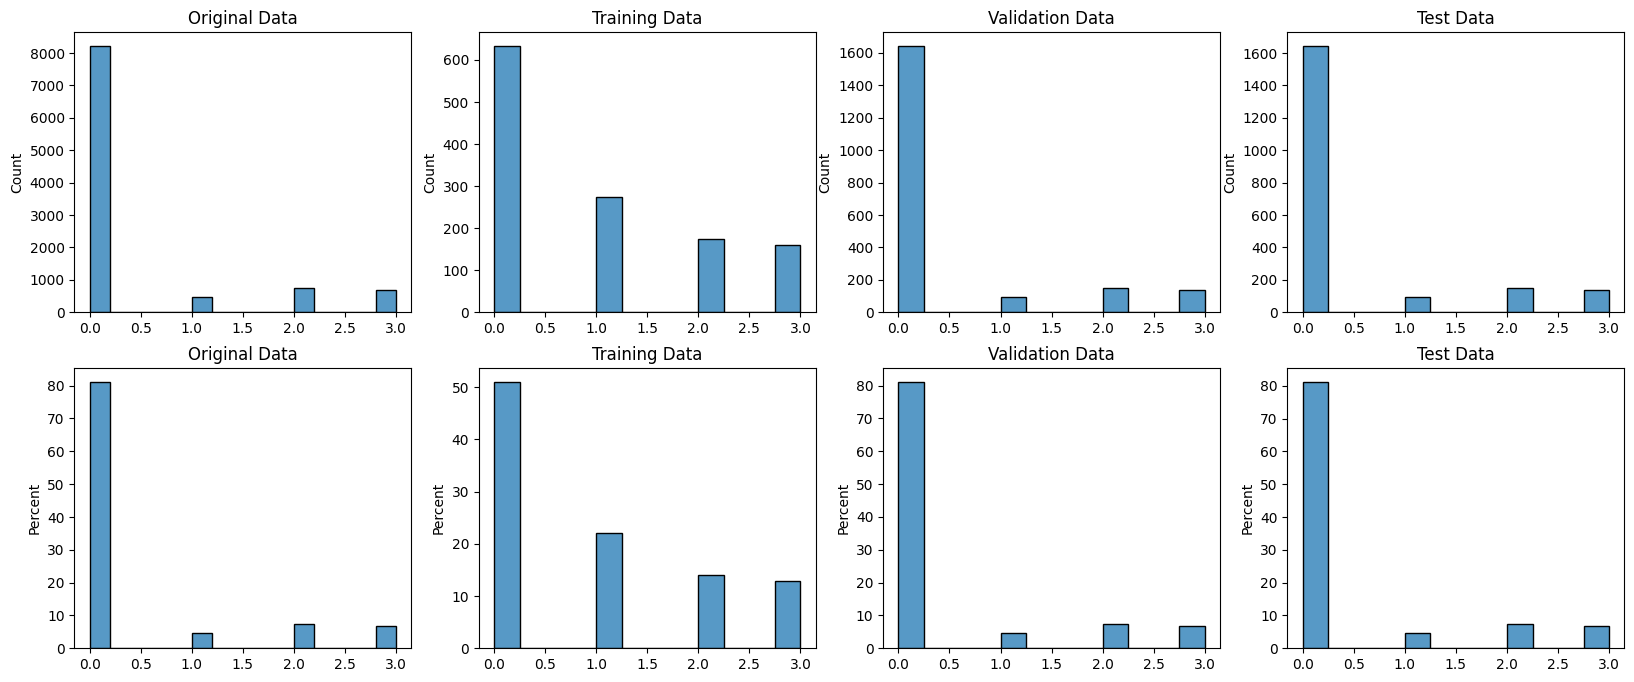

Length of original dataset: 10129

Length of X_train/y_train: 1242/1242
Length of X_val/y_train: 2026/2026
Length of X_test/y_train: 2026/2026

Resulting split: (0.12, 0.20, 0.20)


In [21]:
# Plot showing final distribution of data by class
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

sns.histplot(df[labels], ax=axes[0, 0])
sns.histplot(y_train, ax=axes[0, 1])
sns.histplot(y_val, ax=axes[0, 2])
sns.histplot(y_test, ax=axes[0, 3])

sns.histplot(df[labels], stat="percent", ax=axes[1, 0])
sns.histplot(y_train, stat="percent", ax=axes[1, 1])
sns.histplot(y_val, stat="percent", ax=axes[1, 2])
sns.histplot(y_test, stat="percent", ax=axes[1, 3])

for ax, label in zip(axes[0], ["Original Data", "Training Data", "Validation Data", "Test Data"]):
    ax.set_title(label)
for ax, label in zip(axes[1], ["Original Data", "Training Data", "Validation Data", "Test Data"]):
    ax.set_title(label)

for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

print(f"Length of original dataset: {len(X)}")
print()
print(f"Length of X_train/y_train: {len(X_train)}/{len(y_train)}")
print(f"Length of X_val/y_train: {len(X_val)}/{len(y_val)}")
print(f"Length of X_test/y_train: {len(X_test)}/{len(y_test)}")
print()
print(f"Resulting split: ({len(X_train)/len(X):.2f}, {len(X_val)/len(X):.2f}, {len(X_test)/len(X):.2f})")

### Baseline Model

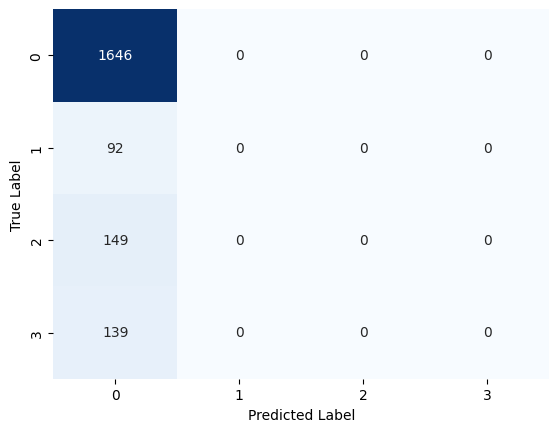

F1-Scores
---------
Macro average:    0.2241
Micro average:    0.8124
Weighted average: 0.7284



In [22]:
# Baseline model always predicts Room_Occupancy_Count == 0
baseline_pred = np.zeros(y_test.shape)

# Display results
sns.heatmap(confusion_matrix(y_test, baseline_pred), annot=True, fmt="g", cmap="Blues", cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

f1_scores = calculate_f1_scores(y_test, baseline_pred)

### Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

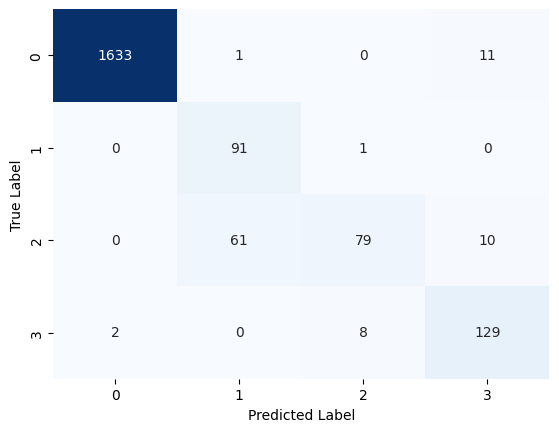

F1-Scores
---------
Macro average:    0.8238
Micro average:    0.9536
Weighted average: 0.9526



In [24]:
# Build and train model
tree = DecisionTreeClassifier(criterion="entropy", random_state=888)
tree.fit(X_train, y_train)

# Make predictions
y_val_pred = tree.predict(X_val)

# Display results
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

f1_scores = calculate_f1_scores(y_val, y_val_pred)

### Logistic Regression

In [25]:
# Boolean for whether to run the hyperparameter optimization
# The optimization takes about 10 minutes to run
RUN_LR_HYPERPARAM_TEST = False

In [26]:
def build_logistic_regression(optimizer="Adam", learning_rate=0.001, loss_fn="categorical_crossentropy", random_seed=888):
    """
    Builds a logistic regression model with the hyperparameters specified

    Parameters
    ----------
    optimizer : str
        The string identifier of a TensorFlow optimizer
        Default: "Adam"
    learning_rate : float
        The learning rate for the optimizer
        Default: 0.001
    loss_fn : str
        The string identifier of the TensorFlow loss function
        Default: "categorical_crossentropy"
    random_seed : int
        The seed for the random number generator
        Default: 888

    Returns
    -------
    model : tf.keras.Sequential
        An instantiation of a TensorFlow sequential model representing a logistic regression
    """
    # Initialization
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)

    # Build model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

    # Initialize optimizer
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.lr.assign(learning_rate)

    # Compile model
    model.compile(
        loss=loss_fn,
        optimizer=optimizer, 
        metrics=[
            tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_macro"),
            tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_micro"),
            tfa.metrics.F1Score(num_classes=4, average="weighted", name="f1_weighted")
        ]
    )
    return model

In [27]:
def build_test_logistic_regression(hyper_params, random_seed=888):
    """
    Wrapper of the "build_logistic_regression" function useful for hyperparameter training

    Parameters
    ----------
    hyper_params : dict
        The dictionary containing hyperparameters with "OPTIMIZER", "LEARNING_RATE",
        "LOSS_FN", and "BATCH_SIZE" as keys
    random_seed : int
        The seed for the random number generator
        Default: 888
    
    Returns
    -------
    f1_scores : tuple
        The macro, micro, and weighted average f1-scores of the model with the
        given hyperparameters
    """
    model = build_logistic_regression(
        optimizer=hyper_params["OPTIMIZER"],
        learning_rate=hyper_params["LEARNING_RATE"],
        loss_fn=hyper_params["LOSS_FN"],
        random_seed=random_seed
    )

    model.fit(
        X_train_std,
        y_train_ohe,
        batch_size=hyper_params["BATCH_SIZE"],
        epochs=1000,
        validation_data=(X_val_std, y_val_ohe),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
        shuffle=True,
        verbose=False
    )

    y_val_pred = np.argmax(model.predict(X_val_std, verbose=1), axis=-1)

    f1_scores = calculate_f1_scores(y_val, y_val_pred, print_output=False)

    return f1_scores

In [28]:
if RUN_LR_HYPERPARAM_TEST:
    # Define the hyperparameter grid space
    OPTIMIZERS = HP_FACTOR("optimizer", ["Adam", "SGD"])
    LEARNING_RATES = HP_FACTOR("learning_rate", [0.001, 0.01, 0.1])
    LOSS_FNS = HP_FACTOR("loss_fn", ["kullback_leibler_divergence", "categorical_crossentropy"])
    BATCH_SIZES = HP_FACTOR("batch_size", [16, 32, 64])

    HP_FACTORS = [OPTIMIZERS, LEARNING_RATES, LOSS_FNS, BATCH_SIZES]
    HP_NAMES = [factor.name for factor in HP_FACTORS]
    HP_VALUES = [factor.values for factor in HP_FACTORS]

    # Iterate over all combinations of hyperparameters and store results
    hp_matrix = itertools.product(*HP_VALUES)
    results = []

    for idx, (optimizer, learning_rate, loss_fn, batch_size) in enumerate(hp_matrix):
        hyper_params = {
            "OPTIMIZER": optimizer,
            "LEARNING_RATE": learning_rate,
            "LOSS_FN": loss_fn,
            "BATCH_SIZE": batch_size
        }
        print(f"--- Starting trial: {idx}")
        print(hyper_params)
        macro_f1, micro_f1, weighted_f1 = build_test_logistic_regression(hyper_params)
        results.append([optimizer, learning_rate, loss_fn, batch_size, macro_f1, micro_f1, weighted_f1])

    # Build dataframe of results for easy model selection
    results = pd.DataFrame(results, columns=HP_NAMES+["macro_f1", "micro_f1", "weighted_f1"])
    results.to_csv("data/post_processing/lr_hyperparam_results.csv")

**Note:** Due to reproducibility issues, the hyperparameter tuning methodology does not always report the same optimal hyperparameter set. By running the hyperparameter selection method multiple times, it was identified that the parameters at trial 10 yield good results.

In [29]:
# Identify best model
if not RUN_LR_HYPERPARAM_TEST:
    results = pd.read_csv("data/post_processing/lr_hyperparam_results.csv", index_col=0)

#best_lr_params = results[results.macro_f1.ge(results.macro_f1.max())].iloc[0]
best_lr_params = results.iloc[10]
best_lr_params

optimizer                            Adam
learning_rate                        0.01
loss_fn          categorical_crossentropy
batch_size                             32
macro_f1                          0.44252
micro_f1                          0.30306
weighted_f1                      0.370559
Name: 10, dtype: object

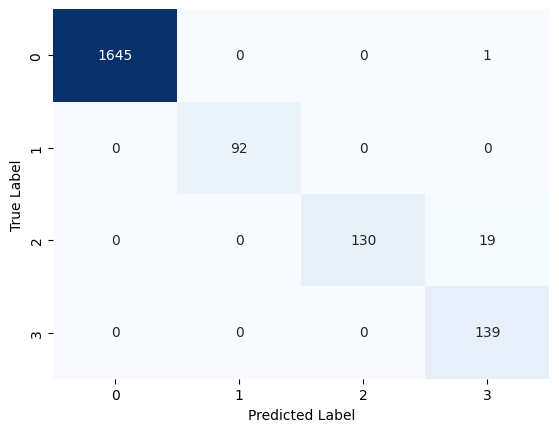

F1-Scores
---------
Macro average:    0.9661
Micro average:    0.9901
Weighted average: 0.9901



In [30]:
# Build and train model using best hyperparameters
model = build_logistic_regression(
    loss_fn=best_lr_params["loss_fn"],
    optimizer=best_lr_params["optimizer"],
    learning_rate=best_lr_params["learning_rate"]
)

history = model.fit(
    X_train_val_std,
    y_train_val_ohe,
    batch_size=best_lr_params["batch_size"],
    epochs=1000,
    validation_data=(X_train_val_test_std, y_test_ohe),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    shuffle=True,
    verbose=False
)

# Make predictions
y_test_pred_prob = model.predict(X_train_val_test_std, verbose=0)
y_test_pred = np.argmax(y_test_pred_prob, axis=-1)

# Display results
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

f1_scores = calculate_f1_scores(y_test, y_test_pred)

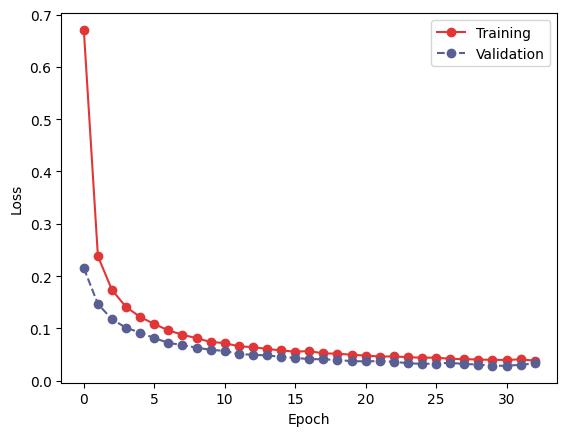

In [31]:
# Display learning curve
history = pd.DataFrame(history.history)
plot_history(history)

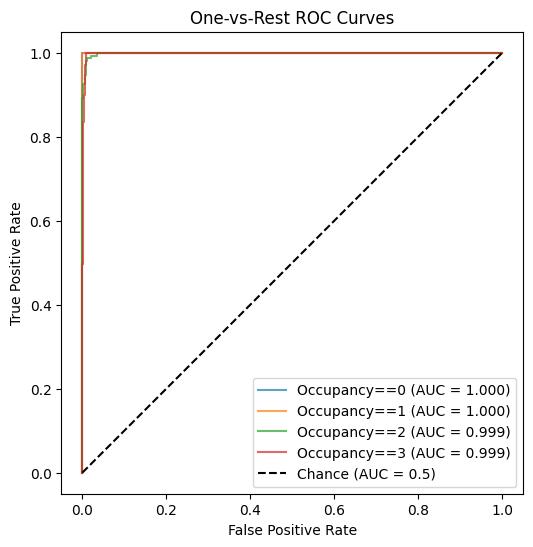

In [32]:
# Display ROC curve
plot_roc(y_test_ohe, y_test_pred_prob)

In [33]:
# Model description
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


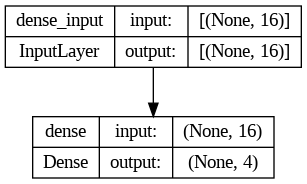

In [34]:
# Model visualization
tf.keras.utils.plot_model(model, show_shapes=True)

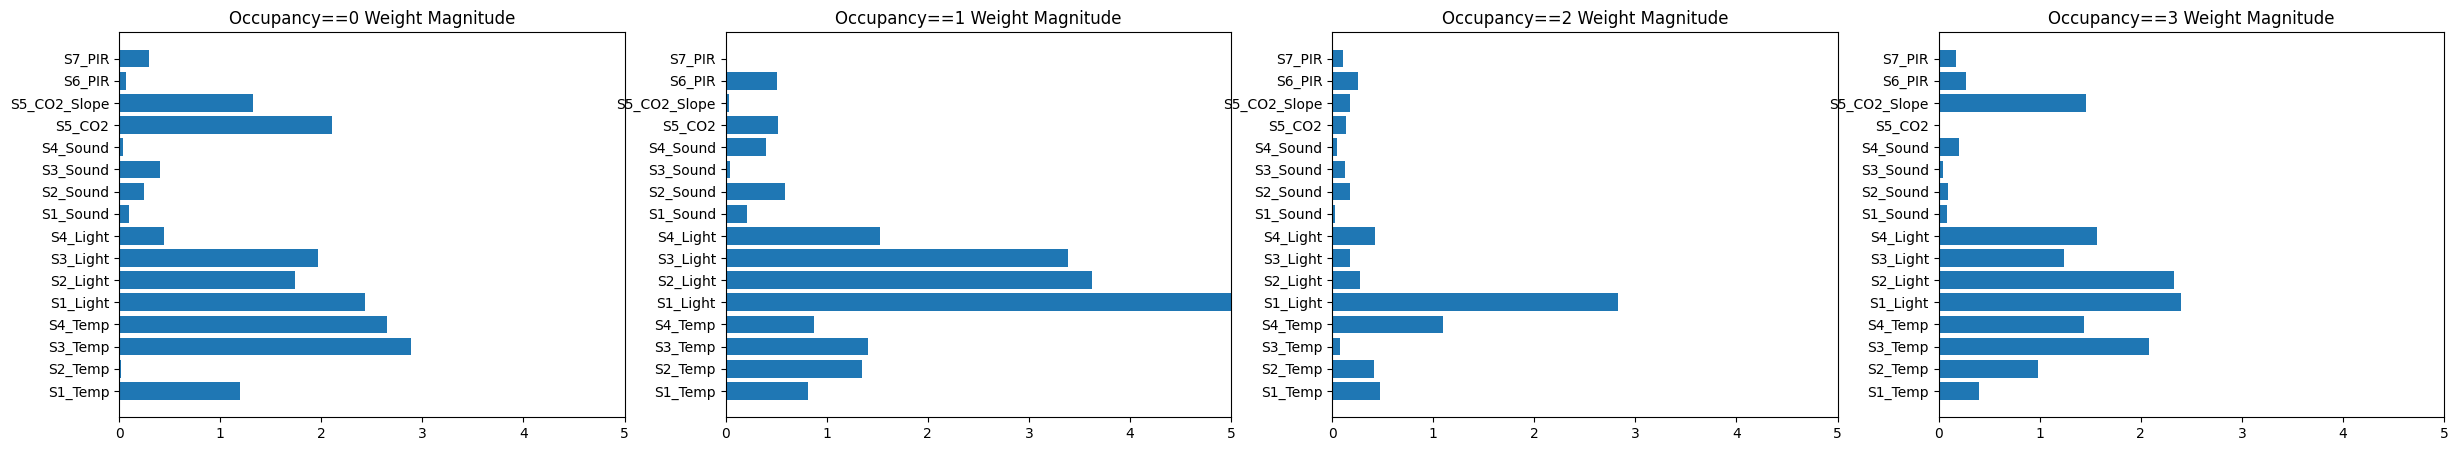

In [35]:
# Weight analysis
weights, biases = model.get_weights()
weights = np.abs(weights)

fig, axes = plt.subplots(1, n_classes, figsize=(30, 5))

for class_id, ax, in enumerate(axes):
    ax.barh(range(len(features)), weights[:,class_id])
    ax.set_yticks(ticks=range(len(features)), labels=features)
    ax.set_title(f"Occupancy=={class_id} Weight Magnitude")
    ax.set_xlim(0, 5)

plt.show()

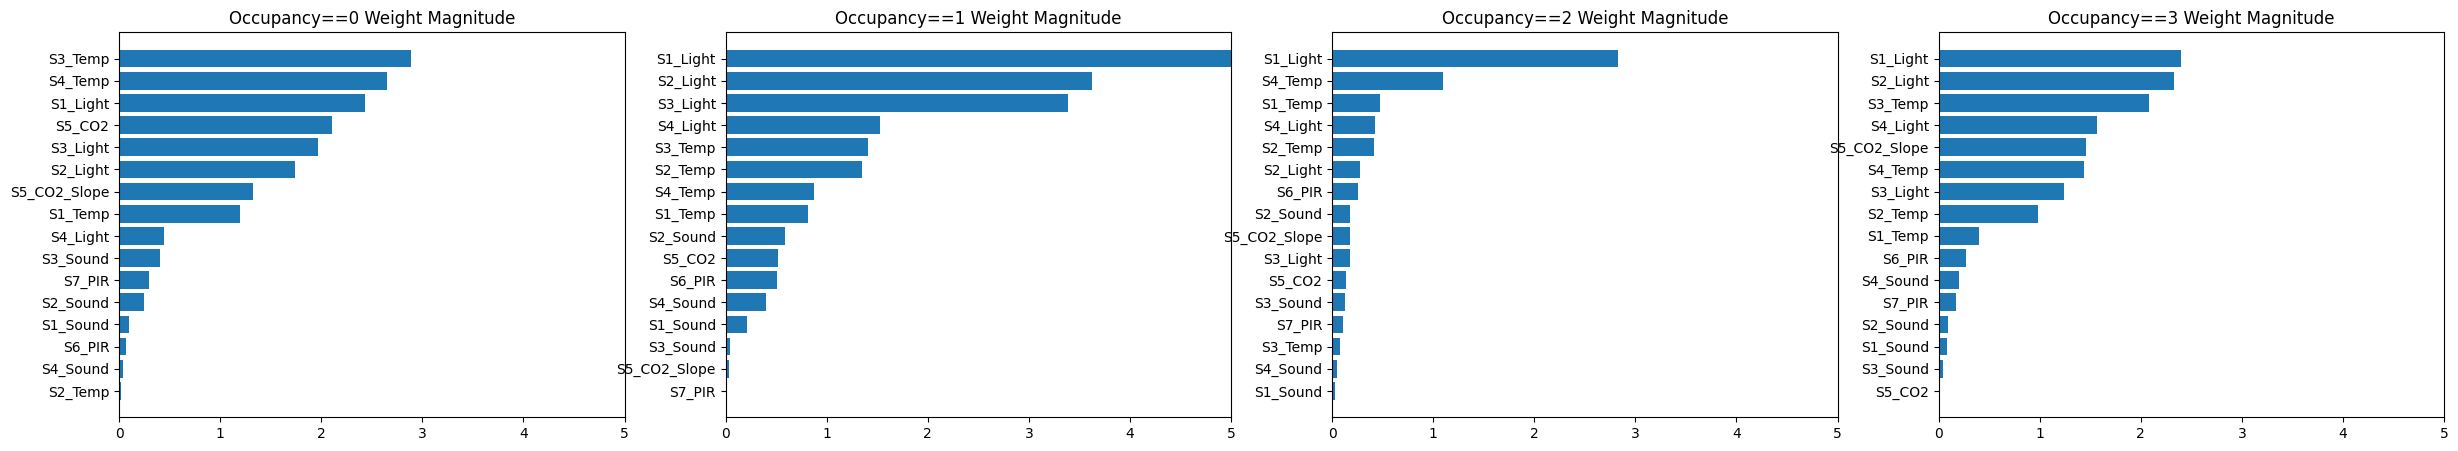

In [36]:
# Sorted weight analysis
fig, axes = plt.subplots(1, n_classes, figsize=(30, 5))

for class_id, ax, in enumerate(axes):
    sort_idx = np.argsort(weights[:,class_id])

    ax.barh(range(len(features)), weights[:,class_id][sort_idx])
    ax.set_yticks(ticks=range(len(features)), labels=features[sort_idx])
    ax.set_title(f"Occupancy=={class_id} Weight Magnitude")
    ax.set_xlim(0, 5)

plt.show()

### Deep Neural Network

In [ ]:
def build_neural_net(feature_shape = len(features), layer1_units=len(features)*2, layer2 = True, 
                     layer2_units = len(features)/2, layer3 = True, layer3_units = len(features)/4, 
                     layer4 = True, layer4_units = len(features)/8, dropout = False, optimizer="Adam", 
                     learning_rate=0.001, loss_fn="categorical_crossentropy", random_seed=888):
    """
    Builds a logistic regression model with the hyperparameters specified

    Parameters
    ----------
    feature_shape : int
        The shape of the input features
        Default: The length of the set of features
    layer1_units : int
        The number of units for the first hidden layer
        Default: The length of features multiplied by 2
    layer2 : bool
        Whether to include a second hidden layer or not
    layer2_units : int
        The number of units for the second hidden layer
        Default: The length of features divided by 2
    layer3 : bool
        Whether to include a third hidden layer or not
    layer2_units : int
        The number of units for the third hidden layer
        Default: The length of features divided by 4
    layer2 : bool
        Whether to include a fourth hidden layer or not
    layer2_units : int
        The number of units for the fourth hidden layer
        Default: The length of features divided by 8
    dropout : bool
        Whether to include a dropout layer or not
        Default: False
    optimizer : str
        The string identifier of a TensorFlow optimizer
        Default: "Adam"
    learning_rate : float
        The learning rate for the optimizer
        Default: 0.001
    loss_fn : str
        The string identifier of the TensorFlow loss function
        Default: "categorical_crossentropy"
    random_seed : int
        The seed for the random number generator
        Default: 888

    Returns
    -------
    model : tf.keras
        An instantiation of a TensorFlow model representing a neural net
    """
    # Initialization
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)

    # Build model
    # first layer: input
    input1 = tf.keras.layers.Input(shape=(feature_shape,), name='Input')

    # second layer: dense (i.e., the nodes are fully connected)
    input2 = tf.keras.layers.Dense(units=(layer1_units), activation='relu', name='fc_1')(input1)
    
    if layer2:
        # third layer: dense (i.e., the nodes are fully connected)
        input3 = tf.keras.layers.Dense(units=(layer2_units), activation='relu', name='fc_2')(input2)
    else:
        input3 = input2
        
    if layer3 and layer2:
        # fourth layer: dense (i.e., the nodes are fully connected)
        input4 = tf.keras.layers.Dense(units=(layer3_units), activation='relu', name='fc_3')(input3)
    else:
        input4 = input3

    if layer4 and layer3 and layer2:
        # fifth layer: dense (i.e., the nodes are fully connected)
        input5 = tf.keras.layers.Dense(units=(layer4_units), activation='relu', name='fc_4')(input4)
    else:
        input5 = input4

    # set dropout layer if desired, else set last input layer to layer3
    if dropout:
        # sixth layer: dropout
        # makes it so some of the nodes in a given layer don’t pass on their information to the next layer. 
        # This helps with computation time (less parameters) and with overfitting.
        input6 = tf.keras.layers.Dropout(rate=0.3, name='Dropout')(input5)
    else:
        input6 = input5

    #the sixth (and last) layer, which is the output layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # logits = natural logarithm of the odds ratio
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    out = tf.keras.layers.Dense(units=4, activation=None, name='fc_5')(input6)

    # instantiate the model
    model = tf.keras.models.Model(inputs=input1, outputs=out)

    # Initialize optimizer
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.lr.assign(learning_rate)
    
    #Initialize loss function              
        #  because our last layer does not apply sigmoid, by specifying from logits=True, 
        #  the loss function applies the sigmoid function internally it's more efficient 
        #  than doing it manually
    if loss_fn == "categorical_crossentropy":
        loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        
    # Compile model
    model.compile(optimizer=optimizer,
              loss=loss_fn,  

              metrics=['accuracy']) # you can add other metrics here
    model.compile(
        loss=loss_fn,
        optimizer=optimizer, 
        metrics=[
            tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_macro"),
            tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_micro"),
            tfa.metrics.F1Score(num_classes=4, average="weighted", name="f1_weighted")
        ]
    )
    return model

In [ ]:
def build_test_neural_net(hyper_params, random_seed=888):
    """
    Wrapper of the "build_logistic_regression" function useful for hyperparameter training

    Parameters
    ----------
    hyper_params : dict
        The dictionary containing hyperparameters with "FEATURE_SHAPE", "LAYER1_UNITS", "LAYER2", "LAYER2_UNITS",
        "DROPOUT", "OPTIMIZER", "LEARNING_RATE", and "LOSS_FN" as keys
    random_seed : int
        The seed for the random number generator
        Default: 888
    
    Returns
    -------
    f1_scores : tuple
        The macro, micro, and weighted average f1-scores of the model with the
        given hyperparameters
    """
    model = build_neural_net(
        feature_shape = hyper_params["FEATURE_SHAPE"],
        layer1_units = hyper_params["LAYER1_UNITS"],
        layer2 = hyper_params["LAYER2"],
        layer2_units = hyper_params["LAYER2_UNITS"],
        layer3 = hyper_params["LAYER3"],
        layer3_units = hyper_params["LAYER3_UNITS"],
        layer4 = hyper_params["LAYER4"],
        layer4_units = hyper_params["LAYER4_UNITS"],
        dropout = hyper_params["DROPOUT"],
        optimizer=hyper_params["OPTIMIZER"],
        learning_rate=hyper_params["LEARNING_RATE"],
        loss_fn=hyper_params["LOSS_FN"],
        random_seed=random_seed
    )

    # set random seed to get reproductible results 
    # neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
    # however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)

    model.fit(X_train_std, tf.one_hot(indices=y_train, depth=4),
                        epochs=1000, 
                        validation_data=(X_val_std, tf.one_hot(indices=y_val, depth=4)),
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
                        shuffle = True,
                        verbose = False
    )

    y_val_pred = np.argmax(model.predict(X_val_std, verbose=1), axis=-1)

    f1_scores = calculate_f1_scores(y_val, y_val_pred, print_output=False)

    return f1_scores

#### Test Hyperparameters

##### `Test All Combinations`

In [ ]:
# This code takes a long time to run
if False:
    # Define the hyperparameter grid space
    hidden_layer_units = [4, 8, 32, 64, 128]
    FEATURE_SHAPE = HP_FACTOR("feature_shape", [len(features)])
    LAYER1_UNITS = HP_FACTOR("layer1_units", hidden_layer_units)
    LAYER2 = HP_FACTOR("layer2", [False, True])
    LAYER2_UNITS = HP_FACTOR("layer2_units", hidden_layer_units)
    LAYER3 = HP_FACTOR("layer3", [False, True])
    LAYER3_UNITS = HP_FACTOR("layer3_units", hidden_layer_units)
    LAYER4 = HP_FACTOR("layer4", [False])
    LAYER4_UNITS = HP_FACTOR("layer4_units", hidden_layer_units)
    DROPOUT = HP_FACTOR("dropout", [False, True])
    OPTIMIZERS = HP_FACTOR("optimizer", ["Adam", "SGD"])
    LEARNING_RATES = HP_FACTOR("learning_rate", [0.001, 0.01, 0.1])
    LOSS_FNS = HP_FACTOR("loss_fn", ["categorical_crossentropy"])

    HP_FACTORS = [FEATURE_SHAPE, LAYER1_UNITS, LAYER2, LAYER2_UNITS, LAYER3, LAYER3_UNITS, LAYER4, LAYER4_UNITS, DROPOUT, OPTIMIZERS, LEARNING_RATES, LOSS_FNS]
    HP_NAMES = [factor.name for factor in HP_FACTORS]
    HP_VALUES = [factor.values for factor in HP_FACTORS]

    # Iterate over all combinations of hyperparameters and store results
    hp_matrix = itertools.product(*HP_VALUES)
    results = []

    for idx, (feature_shape, layer1_units, layer2, layer2_units, layer3, layer3_units, layer4, layer4_units, dropout, optimizer, 
              learning_rate, loss_fn) in enumerate(hp_matrix):
        hyper_params = {
            "FEATURE_SHAPE" : feature_shape,
            "LAYER1_UNITS" : layer1_units,
            "LAYER2" : layer2,
            "LAYER2_UNITS" : layer2_units,
            "LAYER3" : layer3,
            "LAYER3_UNITS" : layer3_units,
            "LAYER4" : layer4,
            "LAYER4_UNITS" : layer4_units,
            "DROPOUT" : dropout,
            "OPTIMIZER": optimizer,
            "LEARNING_RATE": learning_rate,
            "LOSS_FN": loss_fn,
        }
        # do not perform iterations when a higher layer is off
        if not(layer2) and (layer3 or layer4):
            continue
        elif not(layer3) and layer4:
            continue
        # do not repeat iterations for hidden layer sizes when the hidden layer is not included
        elif not(layer2) and layer2_units > min(hidden_layer_units):
            continue
        elif not(layer3) and layer3_units > min(hidden_layer_units):
            continue
        elif not(layer4) and layer4_units > min(hidden_layer_units):
            continue

        print(f"--- Starting trial: {idx}")
        print(hyper_params)
        macro_f1, micro_f1, weighted_f1 = build_test_neural_net(hyper_params)
        results.append([feature_shape, layer1_units, layer2, layer2_units, layer3, layer3_units, layer4, layer4_units,
                        dropout, optimizer, learning_rate, loss_fn, macro_f1, micro_f1, weighted_f1])

    # Build dataframe of results for easy model selection
    results = pd.DataFrame(results, columns=HP_NAMES+["macro_f1", "micro_f1", "weighted_f1"])

In [ ]:
# Only run if you have the results from the previous step
if False:
    # Identify best model
    sorted_results = results.sort_values("macro_f1", ascending = False)
    sorted_results = sorted_results[sorted_results["macro_f1"] > 0.80]
    sorted_results

#### `Test Hyperparamters with macro_f1 greater than 0.8`

In [ ]:
# This code takes a long time to run
if False:
    # Examine the top results with a macro average greater than 0.8 in further detail
    f1_avg = {}
    for i in range(len(sorted_results)):
        best_lr_params = sorted_results.iloc[i] 
        macro_avg =[]
        for j in range(3):
            # Build and train model using best hyperparameters
            model = build_neural_net(
                feature_shape = best_lr_params["feature_shape"],
                layer1_units = best_lr_params["layer1_units"],
                layer2 = best_lr_params["layer2"],
                layer2_units = best_lr_params["layer2_units"],
                layer3 = best_lr_params["layer3"],
                layer3_units = best_lr_params["layer3_units"],
                layer4 = best_lr_params["layer4"],
                layer4_units = best_lr_params["layer4_units"],
                dropout = best_lr_params["dropout"],
                loss_fn=best_lr_params["loss_fn"],
                optimizer=best_lr_params["optimizer"],
                learning_rate=best_lr_params["learning_rate"]
            )

            history = model.fit(
                np.vstack([X_train_std, X_val_std]),
                tf.one_hot(indices=np.hstack([y_train, y_val]), depth=4),
                epochs=1000,
                validation_split=0.2,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)],
                shuffle=True,
                verbose=False
            )

            # Make predictions
            y_val_pred = np.argmax(model.predict(X_val_std, verbose=0), axis=-1)

            f1_scores = calculate_f1_scores(y_val, y_val_pred, print_output = False)
            macro_avg.append(f1_scores[0])
        f1_avg[i] = np.mean(macro_avg)

In [ ]:
# Only run if you have the results from the previous step
if False:
    # Get the true top performers
    # Some hyperparamaters may not be tuned and could have very low scores. We want consistently high average results
    top_params_idx = [idx for idx, val in f1_avg.items() if val >= 0.97]
    sorted_results.iloc[top_params_idx]

#### Further test top 5 results for consistency

In [ ]:
# This code takes a long time to run
if False:
    # Examine the top 5 results in further detail
    f1_avg2 = {}
    for i in top_params_idx[:5]:
        best_lr_params = sorted_results.iloc[i] 
        macro_avg =[]
        for j in range(10):
            # Build and train model using best hyperparameters
            model = build_neural_net(
                feature_shape = best_lr_params["feature_shape"],
                layer1_units = best_lr_params["layer1_units"],
                layer2 = best_lr_params["layer2"],
                layer2_units = best_lr_params["layer2_units"],
                layer3 = best_lr_params["layer3"],
                layer3_units = best_lr_params["layer3_units"],
                layer4 = best_lr_params["layer4"],
                layer4_units = best_lr_params["layer4_units"],
                dropout = best_lr_params["dropout"],
                loss_fn=best_lr_params["loss_fn"],
                optimizer=best_lr_params["optimizer"],
                learning_rate=best_lr_params["learning_rate"]
            )

            history = model.fit(
                np.vstack([X_train_std, X_val_std]),
                tf.one_hot(indices=np.hstack([y_train, y_val]), depth=4),
                epochs=1000,
                validation_split=0.2,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)],
                shuffle=True,
                verbose=False
            )

            # Make predictions
            y_val_pred = np.argmax(model.predict(X_val_std, verbose=0), axis=-1)

            f1_scores = calculate_f1_scores(y_val, y_val_pred, print_output = False)
            macro_avg.append(f1_scores[0])
        f1_avg2[i] = np.mean(macro_avg)

In [ ]:
# Run this to save the new top params
if False:
    top_params_df = sorted_results.iloc[top_params_idx[:5]].assign(avg_f1=f1_avg2.values()).drop(sorted_results.columns[[12,13,14]], axis = 1)
    top_params_df.to_csv("neural_net_top_params.csv")
    top_params_df

#### `Run the model with the best parameters`

In [ ]:
top_params_df = pd.read_csv("data/post_processing/neural_net_top_params.csv")

In [ ]:
# use the params with the maximum f1 score
best_lr_params = top_params_df.iloc[top_params_df['avg_f1'].idxmax()]
best_lr_params

In [ ]:
# Build and train model using best hyperparameters
model = build_neural_net(
    feature_shape = best_lr_params["feature_shape"],
    layer1_units = best_lr_params["layer1_units"],
    layer2 = best_lr_params["layer2"],
    layer2_units = best_lr_params["layer2_units"],
    layer3 = best_lr_params["layer3"],
    layer3_units = best_lr_params["layer3_units"],
    layer4 = best_lr_params["layer4"],
    layer4_units = best_lr_params["layer4_units"],
    dropout = best_lr_params["dropout"],
    loss_fn=best_lr_params["loss_fn"],
    optimizer=best_lr_params["optimizer"],
    learning_rate=best_lr_params["learning_rate"]
)

history = model.fit(
    np.vstack([X_train_std, X_val_std]),
    tf.one_hot(indices=np.hstack([y_train, y_val]), depth=4),
    epochs=1000,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)],
    shuffle=True,
    verbose=False
)

# Make predictions
y_test_pred = np.argmax(model.predict(X_test_std, verbose=0), axis=-1)

# Display results
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('images/confusion_matrix.png', transparent = True)
plt.show()

f1_scores = calculate_f1_scores(y_test, y_test_pred)

In [ ]:
history = pd.DataFrame(history.history)
plot_history(history, save_path="images/nn_history.png", save_kwgs={"transparent": True})

In [ ]:
y_test_pred_prob = model.predict(X_train_val_test_std, verbose=0)
plot_roc(y_test_ohe, y_test_pred_prob, save_path="images/nn_roc.png", save_kwgs={"transparent": True})

#### `Explain the model with Shap`

In [ ]:
# Create proper formatted data frames to pass into Shap
X_df = pd.DataFrame(np.concatenate((X_train_std, X_val_std, X_test_std)), columns = features)
dtypes = X_df.dtypes
X_test_df = pd.DataFrame(X_test_std, columns = features)
for k, v in dtypes.items():
    X_test_df[k] = X_test_df[k].astype(v)

In [ ]:
# This code takes a long time to run
if False:
    # Fits the explainer
    explainer = shap.Explainer(model.predict, X_test_df)
    # Evaluate SHAP values
    shap_values = explainer.shap_values(X_df)

In [ ]:
outputs = [0,1,2,3] # list of possible outputs
color_map = LinearSegmentedColormap.from_list("", ['#595e93', '#e03636'])
# Only run this if performing the shapely explanation
if False:
    for label in outputs:
            plt.suptitle(f'Feature Impact for predicted occupancy count of {label}')
            shap.summary_plot(shap_values[:,:,label],X_test_df,feature_names=features, cmap = color_map, show=False)
            plt.savefig(f'images/plot{label}.png', transparent = True)
            plt.show()

In [ ]:
# Only run this if performing the shapely explanation
if False:
    for label in outputs:
            plt.suptitle(f'Feature Impact for predicted occupancy count of {label}')
            shap.summary_plot(shap_values[:,:,label],X_test_df,feature_names=features, plot_type = 'bar')

In [ ]:
# Only run this if performing the shapely explanation
if False:
    for label in outputs:
            plt.suptitle(f'Feature Impact for predicted occupancy count of {label}')
            shap.summary_plot(shap_values[:,:,label],X_test_df,feature_names=features, plot_type = 'violin')